# BDA Project

Overall Task: Find similar regions by comparing satellite imagery.

In [1]:
from sklearn.neighbors import NearestNeighbors

In [2]:
from numpy import array
from math import sqrt

from pyspark.mllib.clustering import KMeans, KMeansModel

from pyspark import SparkContext, SparkConf
import numpy as np
from PIL import Image
import cv2

import hashlib

import matplotlib.pyplot as plt

In [3]:
sconf = SparkConf().set('spark.driver.memory','12g')
sc = SparkContext(conf=sconf)

In [111]:
BASE_INPUT_PATH = './united_states/'
BASE_RESULT_PATH = './results_last/united_states/'
IMAGE_PATH = '90W/'

***
***
# Find all the tif files 
- Load Tiff Files
- Divide the image into evenly sized 2000x2000 subimages.

In [114]:
def split_images(name, img, new_size=2000):
    factor = int(img.shape[0]/new_size)
    file_name = name.split('/')[-1]
    #     print(factor)
    #     x = rdd_tiff_array.take(1)[0][1]
    w = np.split(img, factor, 1)
    y1 = np.array(w)
    w1 = np.split(y1, factor, 1)
    y = np.array(w1)
    z = y.reshape([y.shape[0]*y.shape[1]]+list(y.shape[2:]))
    
    diff = 10 / factor
    result = list()
    file_name = file_name[:-4]
    lat = float(file_name.split('_')[1][:-1])
    e_w = 1 if file_name.split('_')[1][-1]=='E' else -1
    lng = float(file_name.split('_')[2][:-1])
    n_s = 1 if file_name.split('_')[2][-1]=='S' else -1
    
    complement_dirn = { 'S': 'N', 'N': 'S', 'E': 'W', 'W': 'E'}
    for i, arr in enumerate(z):
        latitude = (lat+n_s*(i%y.shape[0]) * diff)
        longitude = (lng+e_w*(i//y.shape[0]) * diff)
        dirn_lat = file_name.split('_')[1][-1]
        dirn_lng = file_name.split('_')[2][-1]
        if latitude<0:
            latitude = -1*latitude
            dirn_lat = complement_dirn[dirn_lat]
        if longitude<0:
            longitude = -1*longitude
            dirn_lng = complement_dirn[dirn_lng]
        result.append((str(latitude)+dirn_lat+'-'+str(longitude)+dirn_lng, arr))
    return result

def getOrthoTif(x):
    name = x[0].split(':')[1]
    # given a zipfile as bytes (i.e. from reading from a binary file),
    # return a np array of rgbx values for each pixel
    # find tif:
    if name[-4:] == '.tif':  # found it, turn into array:
        print(name)
        img = cv2.imread(name)
        img = img.astype(np.uint8)
        return split_images(name, img)

In [115]:
rdd_1a = sc.binaryFiles(BASE_INPUT_PATH+IMAGE_PATH)
rdd_1b = rdd_1a.flatMap(getOrthoTif)

***
# Calculate the number of pixels for each color:
- Produce a final RDD where each record is of the form: (imagename, array).

***
Print the red, green and black value of some images

In [95]:
def pixel_count(x):
    name, img = x[0], x[1]
    black_px_count = np.argwhere(np.all(img==[0,0,0], axis = 2)).size
    red_px_count = np.argwhere(np.logical_and(img[:, :, 2]>50, img[:, :, 1]==0)).size
    green_px_count = np.argwhere(np.logical_and(img[:, :, 1]>50, img[:, :, 2]==0)).size
    return name, (black_px_count, red_px_count, green_px_count)

rdd_filtered_images = rdd_1b.map(pixel_count).filter(lambda x: x[1][1]>0 or x[1][2]>0)

# Saving entire RDD as text files

In [96]:
%%time
rdd_filtered_images.saveAsTextFile(BASE_RESULT_PATH+IMAGE_PATH)

CPU times: user 33.8 ms, sys: 19.9 ms, total: 53.7 ms
Wall time: 1min 21s


# Sanity of pixel_count method

('90.0W-30.0N', (3283034, 251530, 1107984))


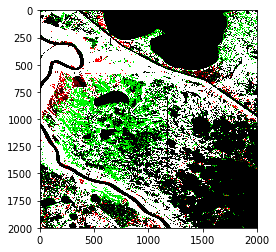

('89.5W-30.0N', (7214822, 28970, 232068))


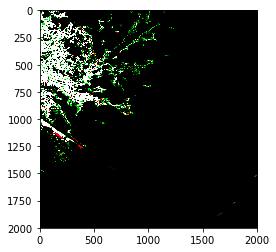

('89.0W-30.0N', (5455842, 3608, 33994))


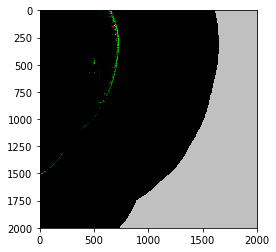

('88.5W-30.0N', (644, 0, 0))


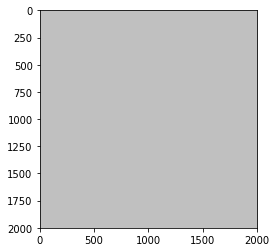

('88.0W-30.0N', (0, 0, 0))


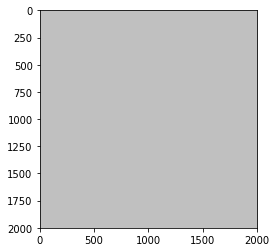

In [116]:
x = rdd_1b.take(5)
for name, img in x:
    print(pixel_count((name, img)))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

# K means clustering
Store cleaned Tiff file to map coordinates with area of depletion and inundation snce 1984

In [97]:
rdd_loc_px_count = sc.textFile(BASE_RESULT_PATH+'*/part-*')

In [98]:
def process_lines(line):
    line = line[1:-1]
    line_split = line.replace("'", '').split(',', 1)
    coords = line_split[0]
    px_count = line_split[1].strip()
    px_count = [int(n.strip()) for n in px_count[1:-1].split(',')]
    return coords, px_count

rdd_records = rdd_loc_px_count.map(process_lines)

# K means clustering
using elbow curve to decide k = 10

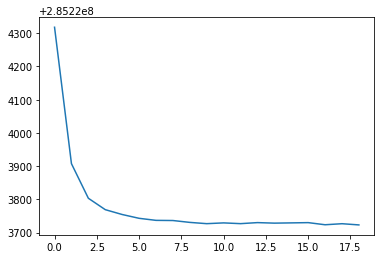

In [99]:
result = []
for k in range(1, 20):
    clusters = KMeans.train(rdd_records.map(lambda x: (x[1][1]/(x[1][1]+x[1][2]), x[1][2]/(x[1][1]+x[1][2]))), k, maxIterations=12, initializationMode="random")

    def error(point):
        x = point[0]/(point[0]+point[1])
        y = point[1]/(point[0]+point[1])                    
        center = clusters.centers[clusters.predict((x, y))]
        return sqrt(sum([x**2 for x in (point - center)]))
    WSSSE = rdd_records.map(lambda x: error(x[1][1:])).reduce(lambda x, y: x + y)
    result.append(WSSSE)
#     print("Within Set Sum of Squared Error = " + str(WSSSE))

plt.plot(result)
plt.show()

In [100]:
clusters = KMeans.train(rdd_records.map(lambda x: (x[1][1]/(x[1][1]+x[1][2]), x[1][2]/(x[1][1]+x[1][2]))), 10, maxIterations=12, initializationMode="random")

def cluster(point):
    u = point[1]/(point[1]+point[2])
    v = point[2]/(point[1]+point[2])
    return clusters.predict((u, v))

rdd_clusters = rdd_records.map(lambda x: (cluster(x[1]), x)).groupByKey().mapValues(list)

# Return K neighbors from within a cluster

Input a query and the number of neighbors you want

In [107]:
def get_top_k_results(lat, lng, k=10, recursion=5):
    if(recursion==0):
        print('Unable to find points nearby')
        return
    query = str(round((lat) * 2) / 2)+'W-'+str(round((lng) * 2) / 2)+'N'
    print(query)
    try:
        _, point = rdd_records.filter(lambda x: x[0]==query).first()
        u = point[1]/(point[1]+point[2])
        v = point[2]/(point[1]+point[2])
        print(u,v, point)
        cluster_num = clusters.predict((u, v))

        cluster_points = rdd_clusters.filter(lambda x: x[0]==cluster_num).first()[1][1:]
        knn = NearestNeighbors(n_neighbors=k)
        points = [x[1][1:] for x in cluster_points]
        knn.fit(points)
        result = [cluster_points[idx] for idx in knn.kneighbors([point[1:]], return_distance=False)[0]]
        return result
    except ValueError:
        print('The lat/lng has no water change, Searching Nearby at: %0.2fW, %0.2fN' % (lat+0.125, lng-0.125))
        return get_top_k_results(lat+.125, lng+0.125, k, recursion-1)

results = get_top_k_results(112.564592, 41.141321)
print(results)

112.5W-41.0N
0.9756894127825241 0.024310587217475938 [2579410, 1353330, 33720]
[('112.5W-41.0N', [2579410, 1353330, 33720]), ('116.0W-32.5N', [8, 1434678, 10]), ('113.5W-41.0N', [20024, 1461736, 62536]), ('118.5W-40.0N', [5618, 1240316, 4616]), ('119.0W-43.5N', [146486, 1482164, 6558]), ('114.0W-41.5N', [14440, 1147394, 10712]), ('113.0W-41.5N', [5097042, 1139238, 1026]), ('113.5W-39.0N', [260, 1019590, 860]), ('119.0W-40.0N', [13618, 1771930, 26888]), ('120.0W-36.5N', [11212, 852236, 37944])]


In [108]:
def show_image_tile(name, pts):
    try:
        img = rdd_1b.filter(lambda x: x[0]==name).first()[1]
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title((name, pts))
        plt.show()
    except ValueError:
        return

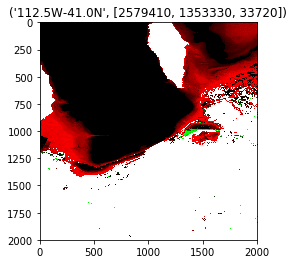

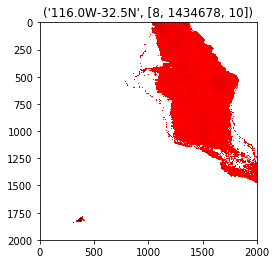

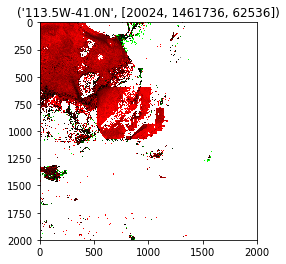

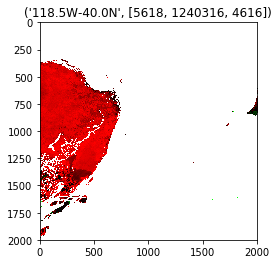

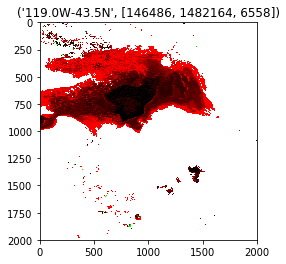

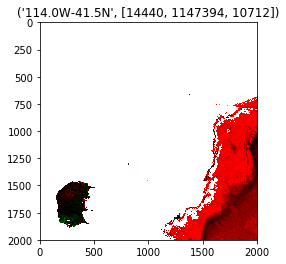

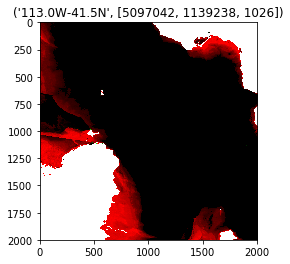

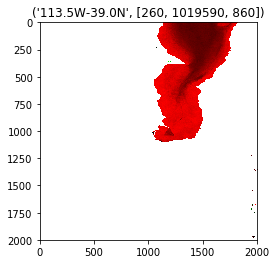

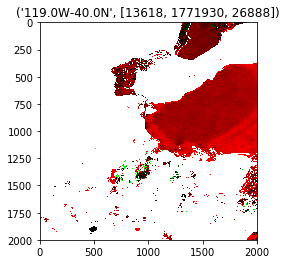

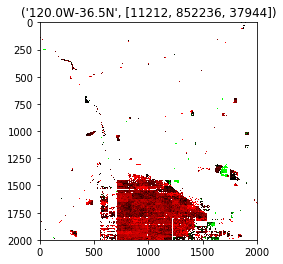

In [109]:
for res in results:
    show_image_tile(res[0], res[1])

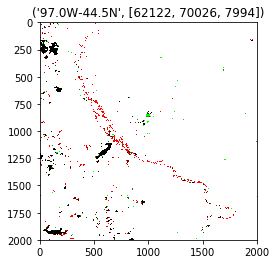

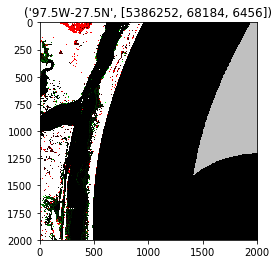

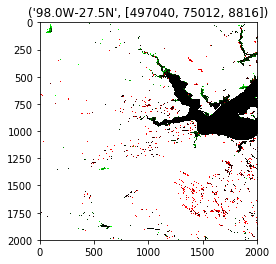

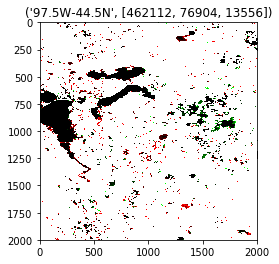

In [66]:
for res in results:
    show_image_tile(res[0], res[1])